In [ ]:
#uncomment and install packages using the following if necessary:
#import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install random2
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install scikit-image
#!{sys.executable} -m pip install scitkit-learn
#!{sys.executable} -m pip install pytorch-lightning
#!{sys.executable} -m pip install torch
#!{sys.executable} -m pip install torchvision

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import cv2 as cv
from skimage import io, transform
from sklearn import preprocessing
import pytorch_lightning as pl

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
data = []
for file in os.listdir('./Data/'): #FIVES dataset
    if file.endswith('.png'):
        data.append(file)
print(len(data)) #checking that there are 200 images

200


/var/folders/dl/2l26ky897xdb2c8k6_0by8tm0000gn/T/ipykernel_26207/1194606612.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


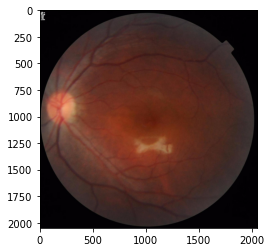

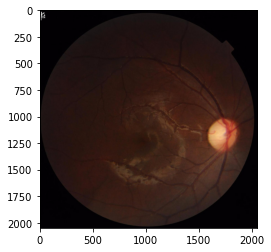

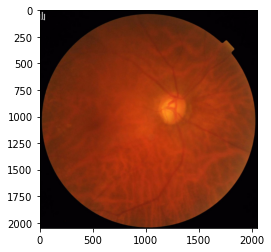

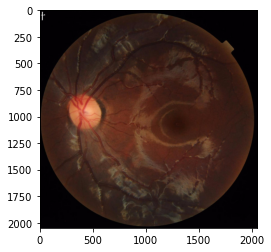

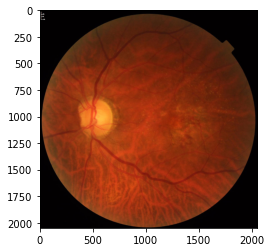

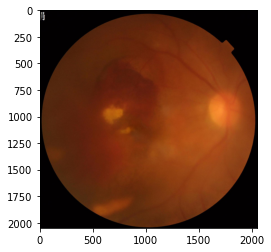

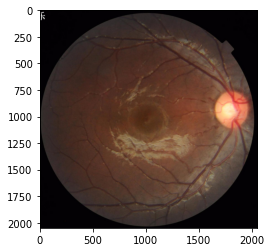

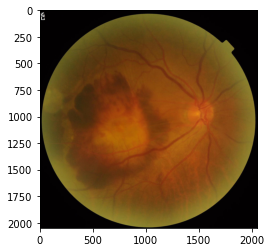

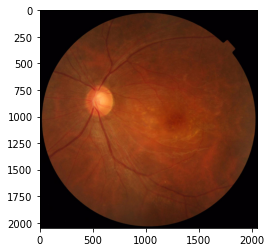

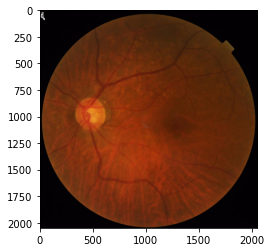

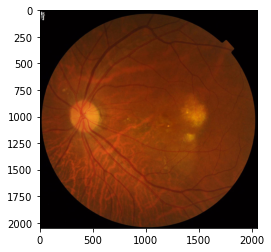

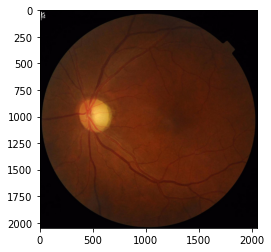

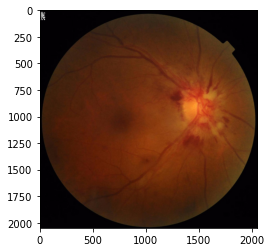

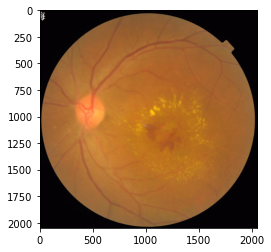

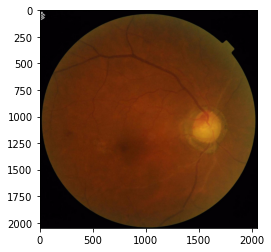

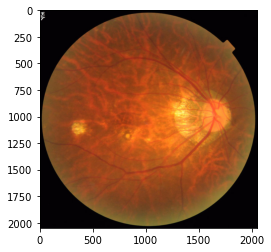

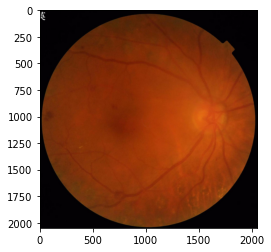

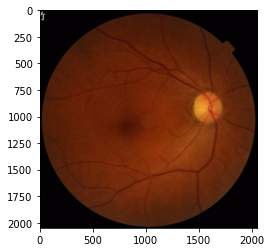

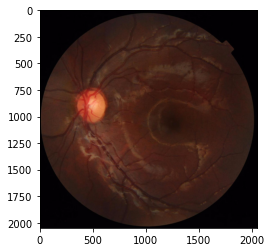

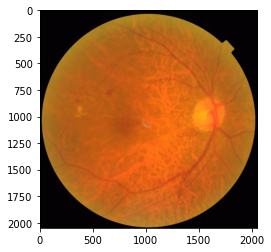

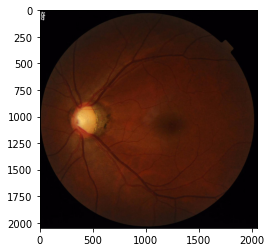

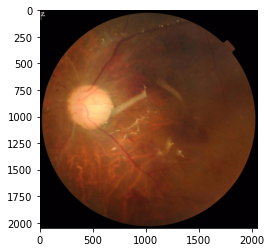

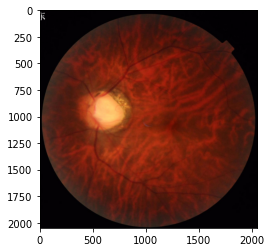

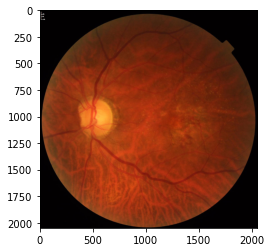

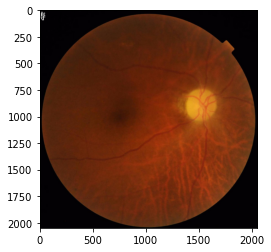

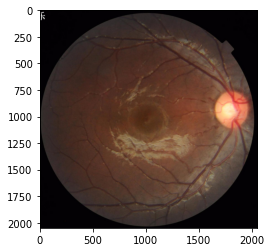

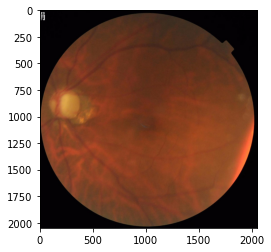

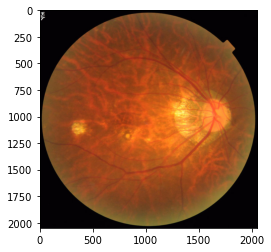

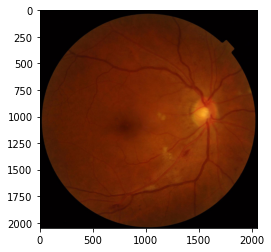

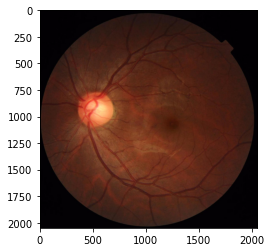

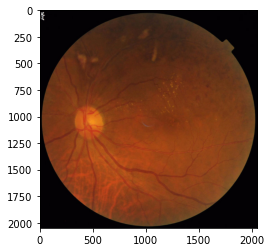

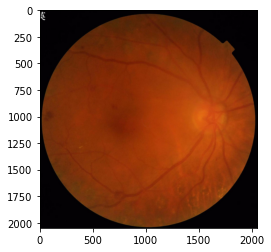

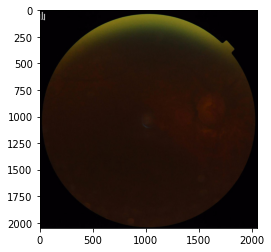

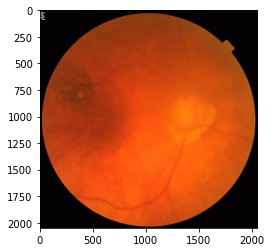

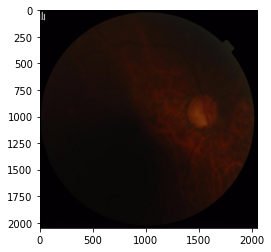

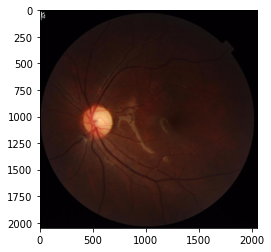

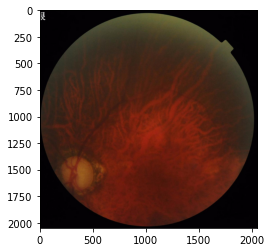

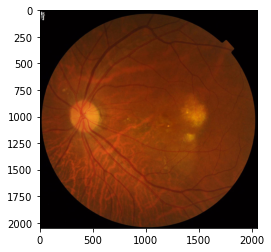

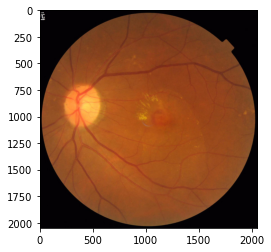

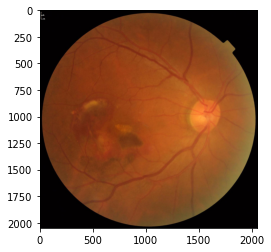

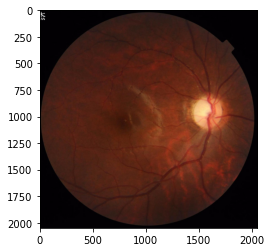

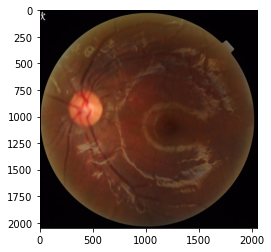

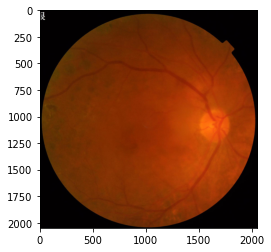

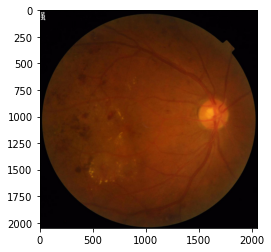

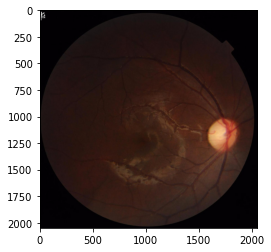

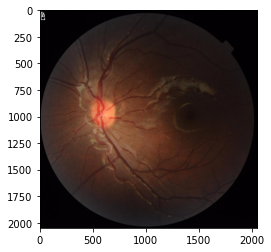

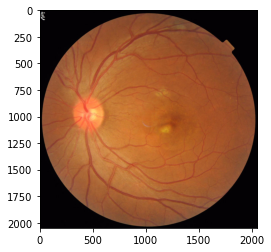

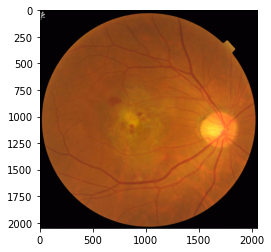

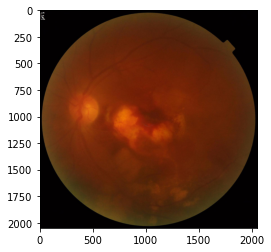

In [5]:
for i in range(50):
    ran = random.choice(data)
    img = plt.imread(os.path.join('./Data/', ran))
    fig = plt.figure()
    plt.imshow(img)
    # size = fig.get_size_inches()*fig.dpi #in case we want to check the image size
    # print(size)

plt.close()

In [4]:
#pixel distribution
diagnosis = {}
for j in data:
    if len(j)<9:
        j = j.zfill(9)
    diagnosis[j[0:3]]= j[4:5]

df = pd.DataFrame(diagnosis.items(), columns=['IMG_no', 'Diagnosis'])

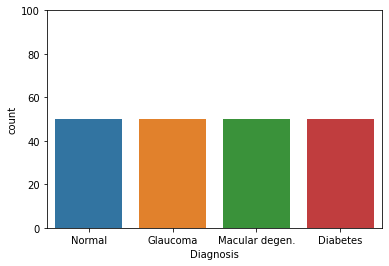

In [7]:
#histogram of diagnoses
ax = sns.countplot(x="Diagnosis",data=df)
ax = ax.set_xticklabels(['Normal', 'Glaucoma', 'Macular degen.', 'Diabetes'])
ax = plt.ylim(0,100)

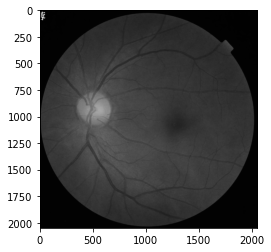

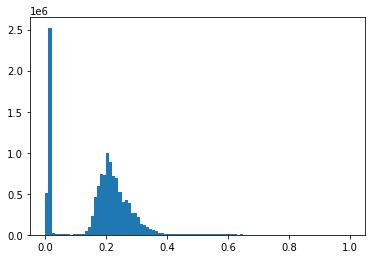

In [144]:
#histogram of intensity distribution
for im in data[0:1]:
    img = plt.imread(os.path.join('./Data/', im))
    img_grey = np.copy(img)
    img_grey[:] = img.mean(axis=-1,keepdims=1)
    plt.imshow(img_grey)
    pixels = img_grey.flatten()

f, ax1 = plt.subplots(1)
cnts, bins = np.histogram(pixels,bins=100)
ax1 = ax1.hist(pixels, bins=100)

In [136]:
img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]

In [137]:
img_r_pixels = img_r.flatten()
img_g_pixels = img_g.flatten()
img_b_pixels = img_b.flatten()

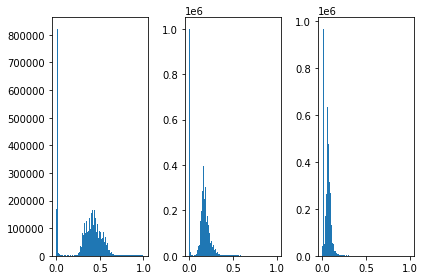

In [142]:
ax2 = plt.subplot(1,3,1)
ax2 = plt.hist(img_r_pixels,bins=100)
ax2 = plt.subplot(1,3,2)
ax2 = plt.hist(img_g_pixels,bins=100)
ax2 = plt.subplot(1,3,3)
ax2 = plt.hist(img_b_pixels,bins=100)
ax2 = plt.tight_layout()

In [5]:
class EyeData(torch.utils.data.Dataset):
    """Eye Images dataset."""

    def __init__(self, data_list, root_dir, labels, transform=None):
        """
        Args:
            data_list (list): List containing name of all the images.
            root_dir (string): Directory with all the images.
            data_lst (list): List containing name of the image labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        label_enc = preprocessing.LabelEncoder()
        labels = labels['Diagnosis']
        labels = label_enc.fit_transform(labels)
        labels = torch.as_tensor(labels)

        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_list[idx])
        image = io.imread(img_name)
        label = self.labels[idx]

        return image, label

In [6]:
transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

eye_dataset = EyeData(data_list=data, root_dir='./Data', labels = df, transform=transform)

In [7]:
print('The shape of tensor for 50th image in train dataset: ',eye_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',eye_dataset[49][1])

The shape of tensor for 50th image in train dataset:  (2048, 2048, 3)
The label for 50th image in train dataset:  tensor(1)


In [8]:
train_set, test_set = torch.utils.data.random_split(eye_dataset, [150, 50])

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=5, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_set, batch_size=5, shuffle=False
)

In [60]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(2048,1024, 3)
        self.pool = torch.nn.MaxPool2d(1)
        self.conv2 = torch.nn.Conv2d(1024, 512, 1)
        self.fc1 = torch.nn.Linear(1047552, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print(x)
        return x

net = CNN()

In [61]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-8)

In [62]:
for epoch in range(2):  # loop over the dataset multiple times

    for i, data_list in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_list

        # # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())


        loss = criterion(outputs, labels)
        if not torch.isnan(loss):
            loss.backward()
            optimizer.step()

        print(epoch+1, loss)

tensor([[-1.9908,  1.5874,  1.0959,  1.7533,  1.2108],
        [-1.8264,  2.0254,  0.3599,  1.6842,  0.8549],
        [-1.4056,  1.2598,  0.9475,  1.8889,  0.9439],
        [-1.3763,  1.4052,  0.1565,  1.4619,  0.4027],
        [-1.8433,  1.9149,  0.4211,  1.3549,  0.8261]],
       grad_fn=<AddmmBackward0>)
1 tensor(2.1995, grad_fn=<NllLossBackward0>)
tensor([[-2.1380,  2.0127,  0.9238,  2.0259,  1.1172],
        [-2.0796,  2.4146,  0.4756,  1.2879,  1.1791],
        [-2.0180,  1.9945,  0.7392,  2.1573,  1.1212],
        [-2.7299,  2.3514,  1.4038,  2.8485,  1.6805],
        [-1.1188,  1.4613,  0.2131,  0.6948,  0.6842]],
       grad_fn=<AddmmBackward0>)
1 tensor(2.1586, grad_fn=<NllLossBackward0>)
tensor([[-2.4393,  2.0446,  0.6402,  1.3762,  0.9817],
        [-3.7568,  3.0191,  1.4644,  3.1856,  1.9191],
        [-2.5078,  2.4930,  1.2896,  2.9121,  1.5670],
        [-2.3318,  1.6348,  0.9252,  1.9171,  0.8246],
        [-1.6799,  1.7377,  1.1548,  2.0312,  1.5926]],
       grad_fn=<

KeyboardInterrupt: 

In [33]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        # calculate outputs by running images through the network
        outputs = net(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

KeyboardInterrupt: 

In [63]:
class CNN_pl(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(2048,1024, 3)
        self.pool = torch.nn.MaxPool2d(1)
        self.conv2 = torch.nn.Conv2d(1024, 512, 1)
        self.fc1 = torch.nn.Linear(1047552, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train_dataloader(self) :
        return torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)

    def val_dataloader(self) :
        return torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=False)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        # forward + backward + optimize
        outputs = net(inputs.float())

        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch

        # forward + backward + optimize
        outputs = net(inputs.float())

        loss_fn = torch.nn.CrossEntropyLoss()
        val_loss = loss_fn(outputs, labels)

        return {'val_loss': val_loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-8)
        scheduler = ReduceLROnPlateau(optimizer)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
           'monitor': 'val_loss'
        }

convolutional_network = CNN_pl()
trainer = pl.Trainer()
trainer.fit(convolutional_network)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/katharinazuehlsdorff/PycharmProjects/Computer-Vision-challenge/lightning_logs

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 18.9 M
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 524 K 
3 | fc1   | Linear    | 268 M 
4 | fc2   | Linear    | 32.9 K
5 | fc3   | Linear    | 645   
------------------------------------
287 M     Trainable params
0         Non-trainable params
287 M     Total params
1,150.429 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

tensor([2, 1, 0, 3, 1])
tensor([[-0.5031,  0.9918,  0.6030,  0.8013,  0.8212],
        [-3.0122,  2.1855,  0.5139,  1.3603,  0.6713],
        [-3.0769,  2.7108,  0.7848,  2.1194,  1.0945],
        [-1.5908,  1.5097,  0.3468,  0.8971,  0.5920],
        [-1.1985,  0.9075,  0.7726,  1.1842,  0.5992]])
tensor([[-0.5031,  0.9918,  0.6030,  0.8013,  0.8212],
        [-3.0122,  2.1855,  0.5139,  1.3603,  0.6713],
        [-3.0769,  2.7108,  0.7848,  2.1194,  1.0945],
        [-1.5908,  1.5097,  0.3468,  0.8971,  0.5920],
        [-1.1985,  0.9075,  0.7726,  1.1842,  0.5992]])
tensor([2, 3, 1, 3, 1])
tensor([[-1.1387,  1.1448,  0.5755,  1.3407,  0.4511],
        [-0.5655,  1.2380,  0.5664,  0.8970,  0.9024],
        [-3.6248,  3.1969,  1.1803,  2.9519,  1.5846],
        [-1.2178,  1.6089,  0.8301,  1.6585,  1.1401],
        [-2.8941,  2.4173,  0.7613,  1.7921,  0.8668]])
tensor([[-1.1387,  1.1448,  0.5755,  1.3407,  0.4511],
        [-0.5655,  1.2380,  0.5664,  0.8970,  0.9024],
        [-3.62

/Users/katharinazuehlsdorff/flux/flux/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/katharinazuehlsdorff/flux/flux/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

tensor([[-1.2521,  1.4795,  0.6896,  1.4865,  1.3036],
        [-1.9204,  1.9511,  0.7037,  2.0960,  1.0890],
        [-2.0303,  1.9753,  0.8878,  1.9592,  1.0900],
        [-2.3723,  2.3976,  1.4225,  2.8969,  1.8229],
        [-2.3766,  1.9827,  1.1126,  2.1684,  1.1316]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.1172,  2.6277,  1.4971,  2.8318,  1.9224],
        [-2.5900,  2.3004,  1.3490,  2.7648,  1.6353],
        [-2.0075,  1.6440,  0.6069,  1.1613,  0.7489],
        [-1.1756,  1.8910,  1.2849,  2.1472,  1.8671],
        [-1.2590,  1.1941,  0.9144,  1.3769,  0.7691]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.5526,  1.8218,  0.8715,  1.6789,  0.6380],
        [-3.1753,  2.6732,  1.2132,  2.6935,  1.2761],
        [-2.5708,  2.6465,  1.2628,  2.7750,  2.0054],
        [-0.8317,  0.6366,  0.5868,  0.8720,  0.5527],
        [-1.3066,  1.7928,  1.1093,  1.5653,  1.3200]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.3818,  1.5549,  0.3406,  0.8556,  0.6177],
        [-2.4640, 

/Users/katharinazuehlsdorff/flux/flux/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
